# Traditional Machine Learning Model Summary

* Each model file has ~50k samples that are split into training and test sets
* We are using logistic regression and Decision Tree. Since we have class imbalanced, I am also experimenting with class_weight parameter
    * LR = Logistic Regression
    * LRB = Logistic Regression with class_weight == 'balanced'
    * DT = Decision Tree
    * DTB = Decision Tree with class_weight == 'balanced'
    * KNN = K Nearest Neighbors
    

Also, we are only initially using Decision Tree to represent our tree based models. If this performs well, we can try other ensemble or boosting methods

## Feature Engineering

| Name | Description |
|------|-------------|
| BoW | Bag of works. Variations using unigram and bigram |
| TFIDF | Term Frequency - Inverse Document Frequency. Variations using unigram and bigram. Max features is set to 10k so we only retain the most frequent 10k words |
| Word2Vec | Word 2 Vec embedding. This is an average embedding of all words in the review. There are 2 variations of this. If it's pretrained, it uses word2vec-google-news-300 else embeddings are trained with our corpus of reviews. Max features is set to 10k so we only retain the most frequent 10k words. Also, there are a couple different version of this using unigram (ngram11) and bigram (ngram22). Max features for this is set to 300 |
| Fasttext | Fasttext embedding. This is an average embedding of all words in the review. Embedding is trained with our corpus of review words. Also, there are a couple different version of this using unigram (ngram11) and bigram (ngram22). Max features for this is set to 300 |


# Summary of Results

* Logistic Regression is generally doing better than tree based model
    * with embedding lengths of 100, 300, 1000, Logistic regression is actually not able to converge at all even when experiementing with number of iterations (up to 300) which leads to a score of 0
* Setting sample_weight to 'balanced' generally improved performance for all models with the most impact on Logistic Regression
* BoW and TF-IDF is generally doing better than embeddings - probably because there are more features available
* TF-IDF does slightly better than BoW's
* ngrams
    * Using unigram actually out performed bigram slightly - this can be explained in our EDA notebook since purely using bigram, we have a significant number of samples without all 0 features
    * TF-IDF with a mix of unigra, bigram, and trigram with 4k max features performed the best out of the variations
* KNN not only was slow to train but overall scored worse that other models

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import importlib
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import util.model_util as mu
import util.report_util as ru
import util.plot_util as pu

%matplotlib inline
sns.set()

CONFIG_DIR = "../config"
CONFIG_FILE = f'{CONFIG_DIR}/2019-11-01-run_classifiers-50k.csv'
REPORT_DIR = "../reports"
REPORT_FILE = f'{REPORT_DIR}/2019-11-01-run_classifiers-50k-report.csv'
REPORT_FILE_KNN = f'{REPORT_DIR}/2019-11-run_classifiers-50k-KNN-report.csv'

/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a fu

# Running our Models

Jupyter notebook was not stable for me when running models for some reason. So I created a program that takes in configuration files and runs all models serially.

To run this again, execute the following command in the tools directory:

```
python run_classifiers.py ../config/2019-11-01-run_classifiers-50k.csv
python run_classifiers.py ../config/2019-11-01-run_classifiers-50k-KNN.csv
```

# Our Configuration File

In [2]:
pd.set_option('max_colwidth', 150)
config = pd.read_csv(CONFIG_FILE)
config.sample(5)

,data_dir,data_file,class_column,dtype,drop_columns,model_name,max_iter,sampling,status,status_date,message
34,../dataset/feature_files,review_body-word2vec-df_none-ngram_none-47523-300-nolda.csv,star_rating,NaN,"helpful_votes, total_votes, helpful_product",DT,NaN,NaN,success,2019-11-03 19:40:03,NaN
51,../dataset/feature_files,review_body-tfidf-df_none-ngram13-49784-4000-nolda.csv,star_rating,NaN,"helpful_votes, total_votes, helpful_product",DTB,NaN,NaN,success,2019-11-05 11:09:57,NaN
1,../dataset/feature_files,review_body-bow-df_default-ngram11-49784-10000-nolda.csv,star_rating,NaN,"helpful_votes, total_votes, helpful_product",LRB,NaN,NaN,success,2019-11-02 12:10:53,NaN
26,../dataset/feature_files,review_body-tfidf-df_default-ngram22-49784-10000-nolda.csv,star_rating,NaN,"helpful_votes, total_votes, helpful_product",DT,NaN,NaN,success,2019-11-02 14:42:10,NaN
9,../dataset/feature_files,review_body-word2vec-df_none-ngram_none-47523-100-nolda.csv,star_rating,NaN,"helpful_votes, total_votes, helpful_product",LRB,NaN,NaN,success,2019-11-02 12:44:01,NaN


# Metrics Evaluation

I want to have one metric that we can use to evaluate our models easier instead of looking at precision and recall for all classes. We saw that there is high class imbalance from our dataset, with most reviews coming in with 5-star ratings.

I want to make sure that we do a better job identifying un-represented classes (ie, 2, 3, 4 star ratings). Instead of using general model accuracy which places equal weights on all classes. I will calculate a metric using the harmonic mean of recall for under represented class (star rating 2, 3, 4) and precision for majority classes (star rating 1 and 5)

Code for this is listed below:

In [3]:
??ru._harmonic_mean

Signature: ru._harmonic_mean(values: list)
Source:   
def _harmonic_mean(values: list):
    """
    Calculates the harmonic mean based on a list of values

    if any of the items in the list is 0, function will return 0

    :param values:
    :return:
    """
    mean = 0
    for v in values:
        if v == 0:
            mean = 0
            break
        else:
            mean += 1 / v
    if mean > 0:
        mean = len(values) / mean

    return mean
File:      ~/Dropbox/0_springboard/capstone/util/report_util.py
Type:      function


# Results

In [4]:
report = ru.load_report(REPORT_FILE)
report_knn = ru.load_report(REPORT_FILE_KNN)
report = report.append(report_knn)

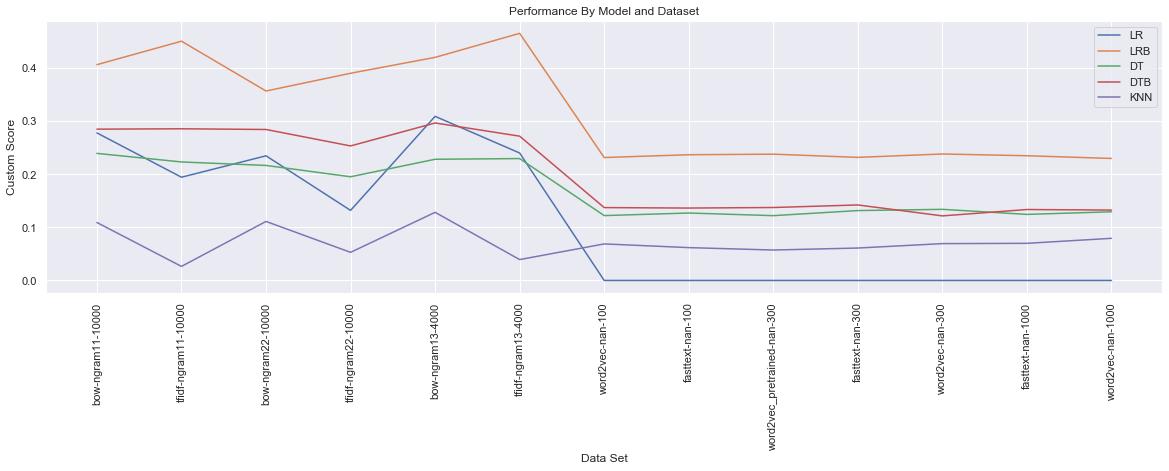

In [5]:
f, a = plt.subplots(1, 1, figsize=(20, 5))

for model in report.model_name.unique():
    current = report[report.model_name == model]
    sns.lineplot(data=current, x="feature_summary", y="eval_metric", label=model, sort=False)
    
_ = plt.title("Performance By Model and Dataset")
_ = plt.xticks(rotation=90)
_ = plt.ylabel("Custom Score")
_ = plt.xlabel("Data Set")

# Recall for Minority Classes

The shape of the lines look roughly the same with values being slightly lower, meaning that the eval_metric we used is generally doing a pretty good job representing recall for minority classes.

There is a tradeoff between recall and precision

* Logistic Regression with balanced class weight has the best average minority class recall
* Logistic Regression without specifying class weight has the best average minority class precision. Although LR with balanced weight still generally beats Decision Trees
* KNN generally did the worse in recalling minority classes

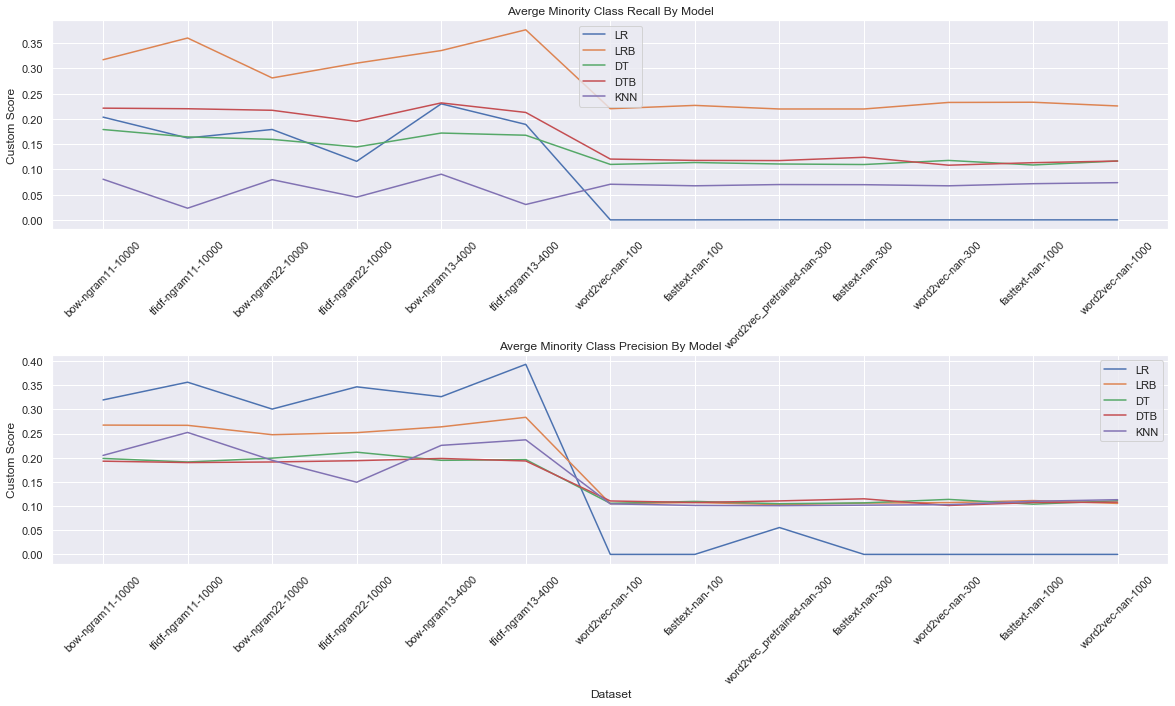

In [6]:
f, a = plt.subplots(2, 1, figsize=(20, 10))

report["minority_recall"] = (report["2_recall"] + report["3_recall"] + report["4_recall"]) /3
report["minority_precision"] = (report["2_precision"] + report["3_precision"] + report["4_precision"]) /3

for model in report.model_name.unique():
    current = report[report.model_name == model]
    sns.lineplot(data=current, x="feature_summary", y="minority_recall", label=model, sort=False, ax=a[0])
    
_ = a[0].set_title("Averge Minority Class Recall By Model")
_ = a[0].set_xticklabels(labels=report.feature_summary.unique(), rotation=45)
_ = a[0].set_ylabel("Custom Score")
_ = a[0].set_xlabel("Dataset")

plt.subplots_adjust(hspace=0.6)


for model in report.model_name.unique():
    current = report[report.model_name == model]
    sns.lineplot(data=current, x="feature_summary", y="minority_precision", label=model, sort=False, ax=a[1])
    
_ = a[1].set_title("Averge Minority Class Precision By Model")
_ = a[1].set_xticklabels(labels=report.feature_summary.unique(), rotation=45)
_ = a[1].set_ylabel("Custom Score")
_ = a[1].set_xlabel("Dataset")

# Average Peroformance

* On average, tree based models are doing better than Logistic Regression alone. However, when class_weight is specific to be 'balanced', LR out performs tree based model.

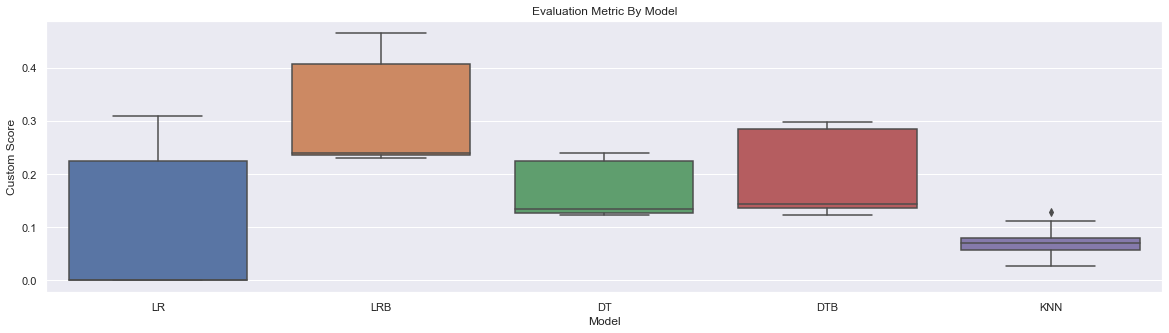

In [7]:
f, a = plt.subplots(1, 1, figsize=(20, 5))

sns.boxplot(data=report, x="model_name", y="eval_metric")
_ = plt.title("Evaluation Metric By Model")
_ = plt.xlabel("Model")
_ = plt.ylabel("Custom Score")




# Looks at Specific Score for LRB Model

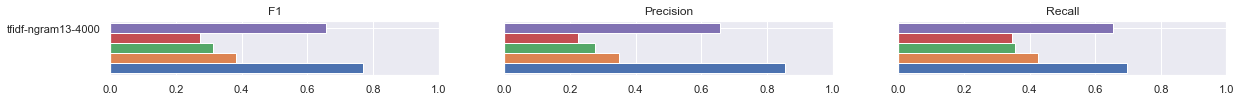

In [8]:
importlib.reload(ru)
importlib.reload(pu)

best = ru.load_best_from_report(report)
pu.plot_score_histograms(best, version=2)



# Training Time

In [9]:
report.total_time_min = report.train_time_min + report.predict_time_min

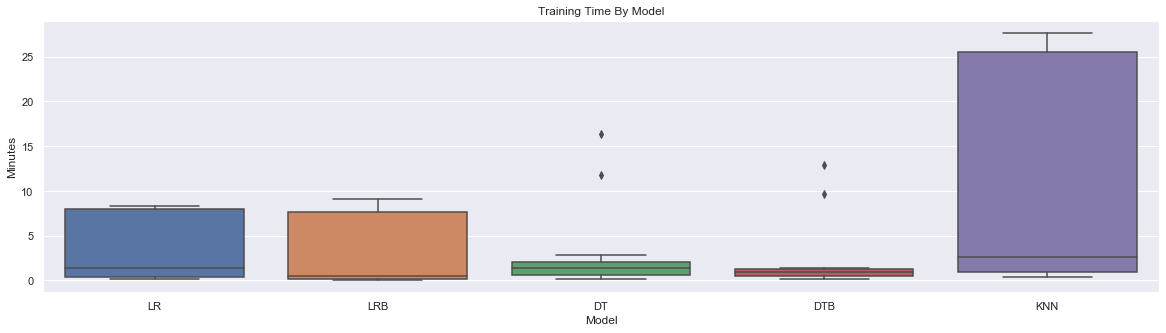

In [10]:
f, a = plt.subplots(1, 1, figsize=(20, 5))

sns.boxplot(data=report, x="model_name", y="total_time_min")
_ = plt.title("Training Time By Model")
_ = plt.xlabel("Model")
_ = plt.ylabel("Minutes")